<a href="https://colab.research.google.com/github/Masakinka/python_for_ds_task/blob/main/HW_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro
import scipy.stats as stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/train.csv.zip", compression='zip')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [ ]:
print(data.head(10))
print(data.info())

            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
2013-01-06      1     1     12
2013-01-07      1     1     10
2013-01-08      1     1      9
2013-01-09      1     1     12
2013-01-10      1     1      9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None


In [ ]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



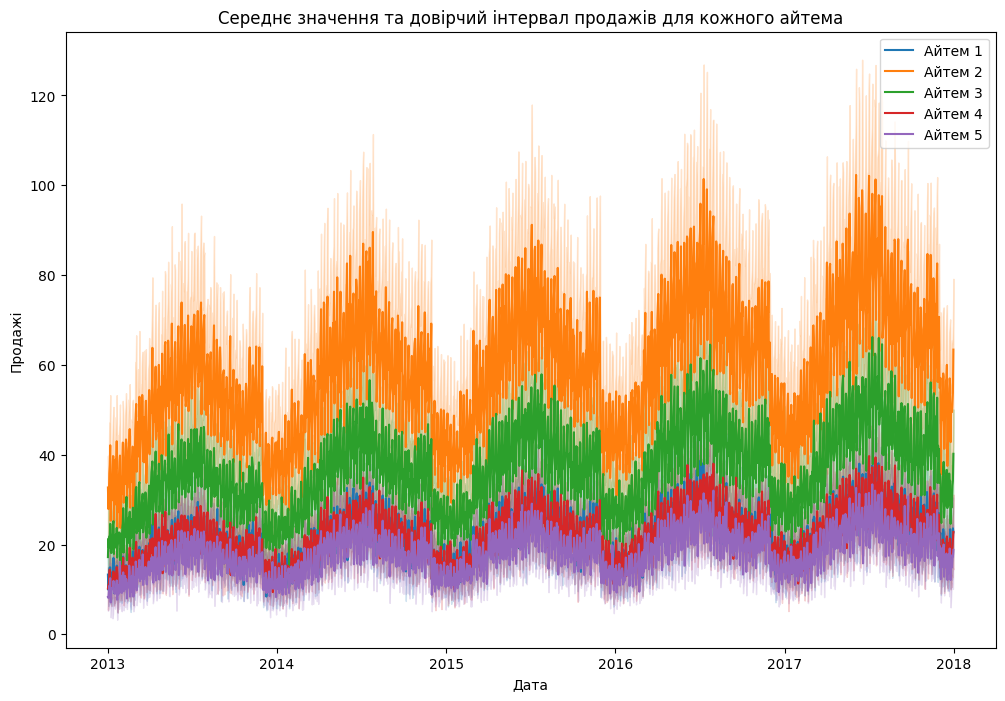

In [ ]:
# Вибір кількох айтемів для відображення
items_to_plot = data['item'].unique()[:5]  # Вибираємо перші 5 айтемів

plt.figure(figsize=(12, 8))

# Цикл по вибраним айтемам
for item in items_to_plot:
    subset = data[data['item'] == item]
    sns.lineplot(x=subset.index, y=subset['sales'], errorbar='sd', label=f'Айтем {item}')

plt.title('Середнє значення та довірчий інтервал продажів для кожного айтема')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()

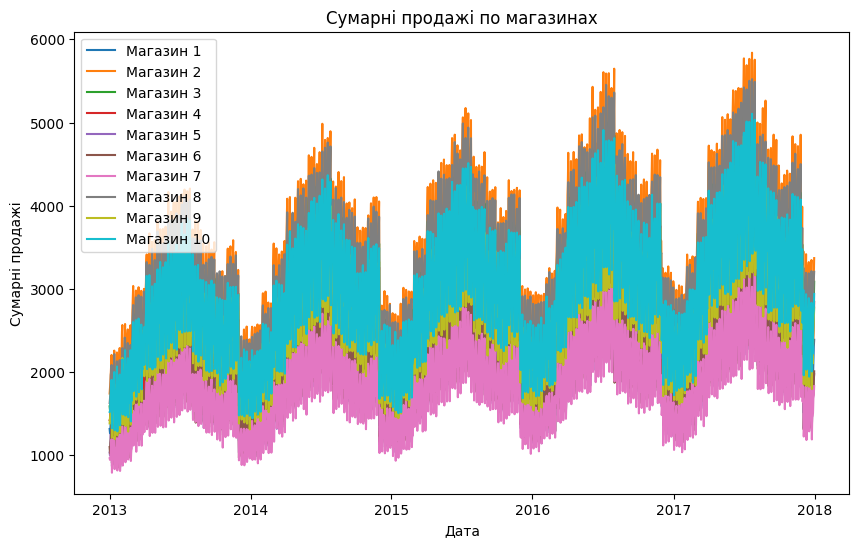

In [ ]:
# Графік сумарних продажів всіх товарів по магазинах
plt.figure(figsize=(10, 6))
for store in data['store'].unique():
    store_data = data[data['store'] == store].groupby('date')['sales'].sum()
    plt.plot(store_data.index, store_data, label=f'Магазин {store}')

plt.title('Сумарні продажі по магазинах')
plt.xlabel('Дата')
plt.ylabel('Сумарні продажі')
plt.legend()
plt.show()

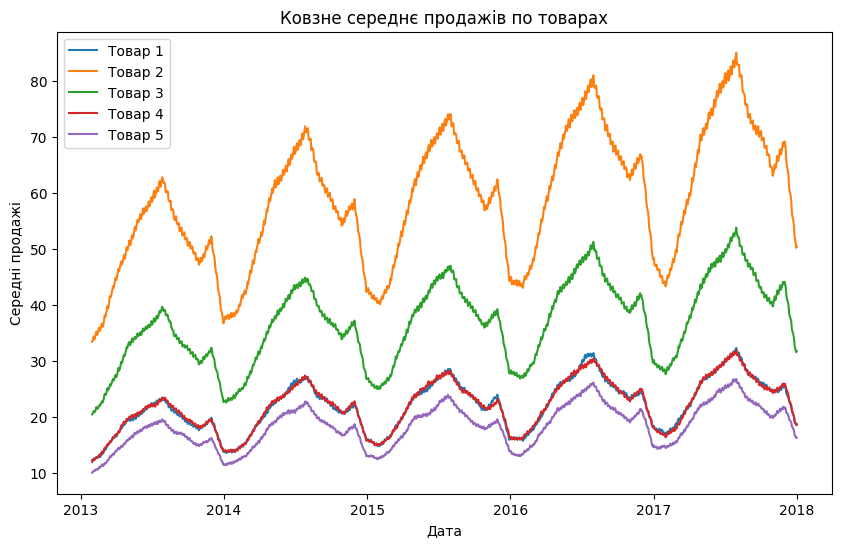

In [ ]:
plt.figure(figsize=(10, 6))
for item in data['item'].unique()[:5]:  # Перевірка для 5 товарів
    item_data = data[data['item'] == item].groupby('date')['sales'].mean().rolling(window=30).mean()
    plt.plot(item_data.index, item_data, label=f'Товар {item}')

plt.title('Ковзне середнє продажів по товарах')
plt.xlabel('Дата')
plt.ylabel('Середні продажі')
plt.legend()
plt.show()


 **Висновок**: динаміка продажів товарів має виражені сезонні коливання. Це можна побачити на графіках сумарних продажів і ковзного середнього, де продажі пікові в певні періоди року. Аналіз довірчих інтервалів показує, що певні товари мають більшу варіабельність продажів у порівнянні з іншими, що може вказувати на різні впливи зовнішніх факторів на попит.

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [ ]:
# Вибір підмножини даних
subset = data[(data['item'] == 1) & (data['store'] == 1)]

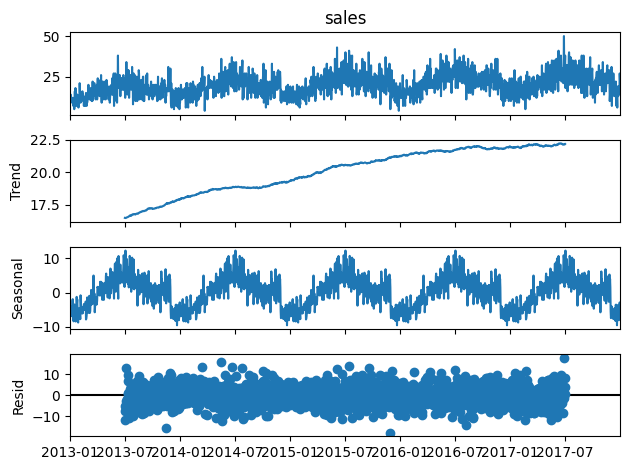

In [ ]:
# Декомпозиція часового ряду
decomposition = seasonal_decompose(subset['sales'], model='additive', period=365)

# Відображення компонентів
decomposition.plot()
plt.show()

1. Sales графік показує, що ряд досить варіабельний з постійними коливаннями протягом усього періоду.
2. Тренд показує довгострокову тенденцію зростання продажів з 2013 по 2017 рік.
Це може свідчити про поступове збільшення популярності товару або про інші фактори, такі як покращення маркетингових стратегій або зміни в асортименті товарів.
3. Сезонність відображає регулярні коливання, що повторюються щороку. На графіку добре видно сезонні піки та спади.
Такі піки можуть бути пов'язані зі святами, промоакціями або іншими подіями, що мають вплив на поведінку покупців.
4. Залишки (residuals) представляють шум або випадкові варіації, які не можуть бути пояснені трендом або сезонністю.

**Висновки**: Декомпозиція показує, що продажі товару зростають протягом всього періоду з вираженою сезонною компонентою.
Сезонність важлива для розуміння того, коли відбуваються піки продажів і коли очікувати спадів.
Відсутність помітних патернів у залишках вказує на те, що основні компоненти часового ряду були правильно виявлені.

Що можно зробити додатково:
-  Аналіз залишків: Ви можете додатково проаналізувати залишки, перевіривши їх на наявність автокореляції або інших статистичних властивостей, які можуть дати уявлення про інші фактори, що впливають на продажі.
- Порівняння з іншими моделями: можна спробувати мультиплікативну модель для перевірки, чи краще вона описує дані.

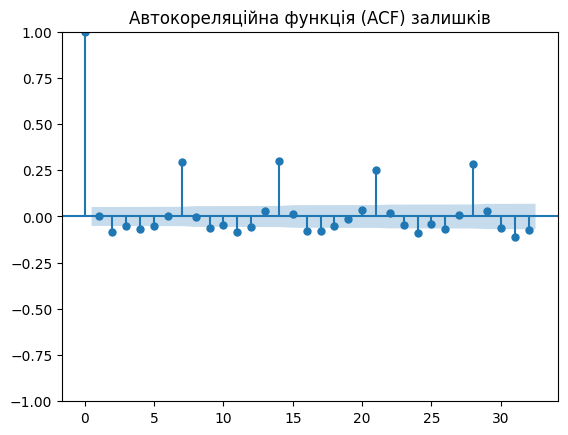

In [ ]:
# Побудова ACF для залишків
plot_acf(decomposition.resid.dropna())
plt.title('Автокореляційна функція (ACF) залишків')
plt.show()

На графіку ACF видно, що перша автокореляція значно відрізняється від нуля, а інші автокореляції переважно знаходяться в межах довірчого інтервалу.
Висновок: Це може вказувати на те, що деяка залежність між спостереженнями все ж таки існує, але вона не є значною після першого лага. Загалом, залишки виглядають майже випадковими, що свідчить про те, що модель добре описує тренд і сезонність.

W-статистика: 0.998730099016241, p-значення: 0.3774649394825057


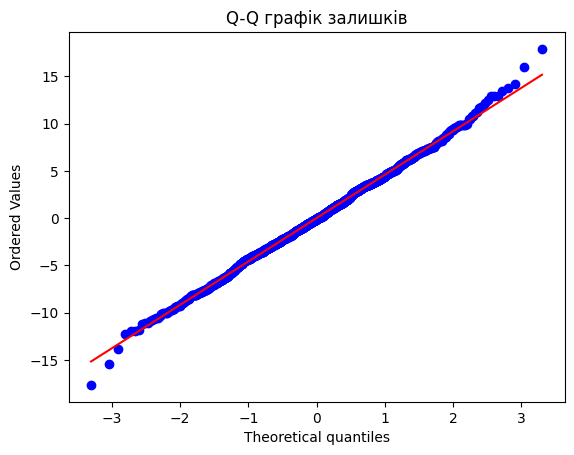

In [ ]:
# Тест Шапіро-Вілка
stat, p_value = shapiro(decomposition.resid.dropna())
print(f'W-статистика: {stat}, p-значення: {p_value}')

# Q-Q графік для залишків
stats.probplot(decomposition.resid.dropna(), dist="norm", plot=plt)
plt.title('Q-Q графік залишків')
plt.show()

Q-Q графік показує, що більшість точок залишків лежать близько до діагоналі, що вказує на нормальний розподіл залишків. Однак, є кілька відхилень на кінцях графіка.
Висновок: Невеликі відхилення на краях можуть вказувати на наявність деяких екстремальних значень або впливу аномальних даних, але в цілому розподіл залишків близький до нормального.

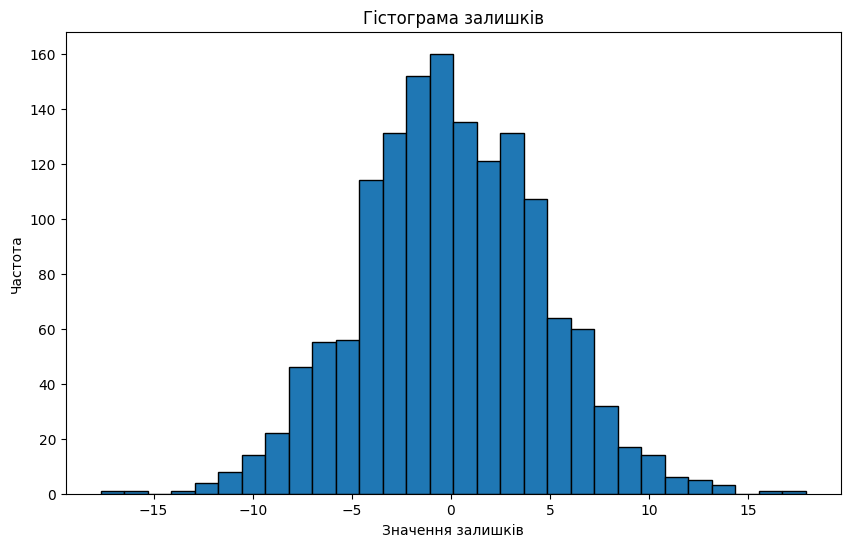

In [ ]:
# Побудова гістограми залишків
plt.figure(figsize=(10, 6))
plt.hist(decomposition.resid.dropna(), bins=30, edgecolor='k')
plt.title('Гістограма залишків')
plt.xlabel('Значення залишків')
plt.ylabel('Частота')
plt.show()

Гістограма має дзвоновидну форму, що підтверджує, що розподіл залишків наближений до нормального.
Висновок: Розподіл залишків відповідає нормальному розподілу, що є бажаним для моделювання. Це свідчить про те, що модель добре описує дані.

Загальний висновок:
1. Модель, яку ви використовуєте для декомпозиції часового ряду, добре підходить для ваших даних.
2. Залишки є майже випадковими, що вказує на те, що тренд і сезонність були коректно ідентифіковані.
3. Невеликі відхилення в автокореляційній функції та Q-Q графіку можуть бути пов'язані з деякими аномаліями в даних або несподіваними подіями, які не можуть бути передбачені моделлю.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [ ]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 516.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 41.4 MB/s eta 0

In [ ]:
from darts import TimeSeries

In [ ]:
# Створення об'єкта TimeSeries для колонки 'sales'
series = TimeSeries.from_dataframe(subset, value_cols='sales')

# Перевірка об'єкта TimeSeries
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

In [ ]:
# Розбиття даних, де валідація починається з 2017-10-01 включно
train, val = series.split_before(pd.Timestamp("2017-10-01"))

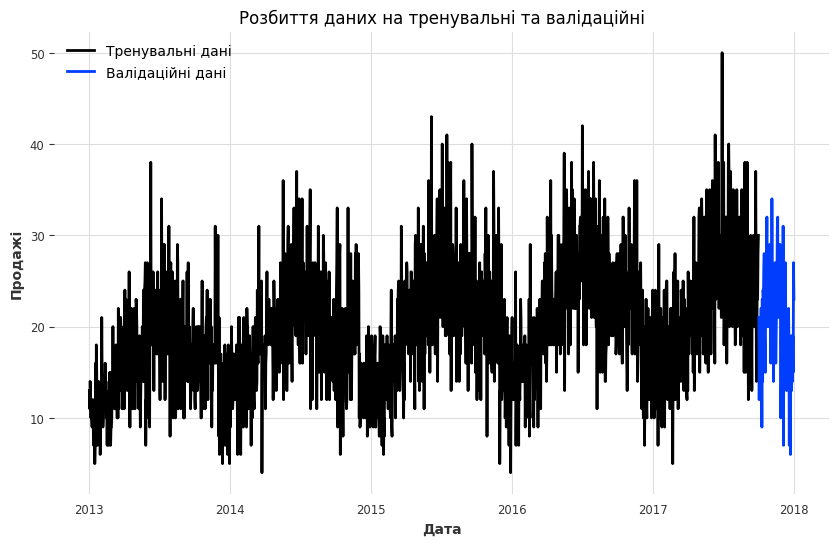

In [ ]:
# Візуалізація тренувального та валідаційного наборів на одному графіку
plt.figure(figsize=(10, 6))
train.plot(label='Тренувальні дані')
val.plot(label='Валідаційні дані')
plt.title('Розбиття даних на тренувальні та валідаційні')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

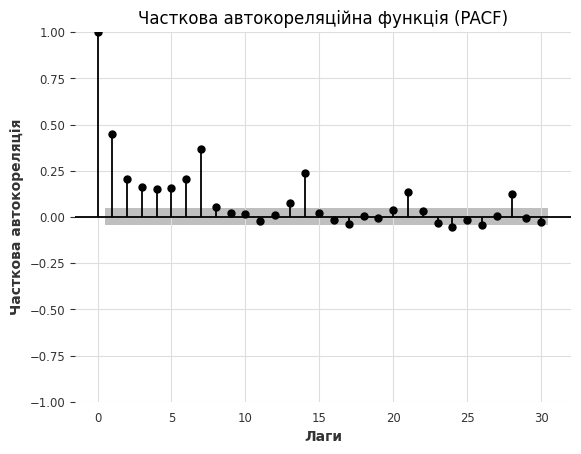

In [ ]:
# Побудова часткової автокореляційної функції (PACF)
plot_pacf(series.values(), lags=30, method='ywm')
plt.title('Часткова автокореляційна функція (PACF)')
plt.xlabel('Лаги')
plt.ylabel('Часткова автокореляція')
plt.show()

1. Значущі лаги:
Лаги 1, 2, 3 і 4 мають значну часткову автокореляцію, що свідчить про те, що ці лаги мають сильний вплив на поточне значення часового ряду.
Також помітний значущий вплив на лагу 7 і 15. Це може вказувати на потенційну сезонність або періодичність у даних.
2. Важливість лагів для прогнозування:
Лаги, які показують значущу часткову автокореляцію (переважно 1-4), вказують на те, що ці лаги можуть бути корисними при моделюванні і прогнозуванні цього часового ряду.
3. Інші лаги мають автокореляцію, близьку до нуля, що свідчить про те, що вони не мають значного впливу на прогнозування.

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [ ]:
from darts.utils.statistics import check_seasonality

In [ ]:
# Перевірка сезонності для тренувального ряду
is_seasonal, period = check_seasonality(train, max_lag=365)

if is_seasonal:
    print(f"Ряд є сезонним з періодом {period}.")
else:
    print("Сезонність не виявлена.")

Ряд є сезонним з періодом 7.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [ ]:
from darts.models import NaiveSeasonal, NaiveDrift

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Створення наївної моделі NaiveSeasonal з періодом 7 (який був визначений раніше)
model_seasonal = NaiveSeasonal(K=7)

# Створення наївної моделі NaiveDrift
model_drift = NaiveDrift()

In [ ]:
# Навчання та прогнозування для NaiveSeasonal
model_seasonal.fit(train)
forecast_seasonal = model_seasonal.predict(len(val))

# Навчання та прогнозування для NaiveDrift
model_drift.fit(train)
forecast_drift = model_drift.predict(len(val))

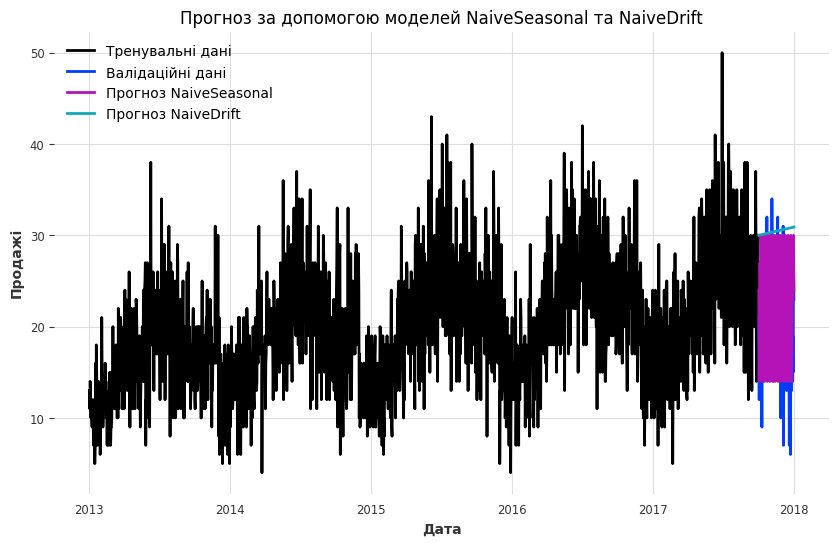

In [ ]:
plt.figure(figsize=(10, 6))

# Візуалізація тренувальних даних
train.plot(label='Тренувальні дані')

# Візуалізація валідаційних даних
val.plot(label='Валідаційні дані')

# Візуалізація прогнозів NaiveSeasonal
forecast_seasonal.plot(label='Прогноз NaiveSeasonal')

# Візуалізація прогнозів NaiveDrift
forecast_drift.plot(label='Прогноз NaiveDrift')

plt.title('Прогноз за допомогою моделей NaiveSeasonal та NaiveDrift')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()


Висновки щодо результатыв:
1. NaiveSeasonal використовує просту сезонну модель з періодом 7, яка повторює значення з минулого сезону (тижня).
2. NaiveDrift прогнозує на основі тенденції, додаючи або віднімаючи середній приріст за останній період до останнього значення.
3. Обидві моделі є дуже простими і часто слугують базовою лінією для порівняння з більш складними моделями.
На графіку видно, що моделі NaiveSeasonal і NaiveDrift можуть забезпечити початковий прогноз, однак вони не враховують більш складні тренди та сезонність, що може бути присутнім у даних. Як результат, моделі можуть давати значні відхилення від реальних даних.
4. Моделі NaiveSeasonal і NaiveDrift можна використовувати для швидкого оцінювання або як базові моделі для порівняння з більш складними підходами.

Спробуємо трохи покращыти результати.

Одним з варіантів може бути комбінація прогнозів від NaiveSeasonal і NaiveDrift. Це дозволить врахувати як сезонний компонент, так і тренд одночасно.

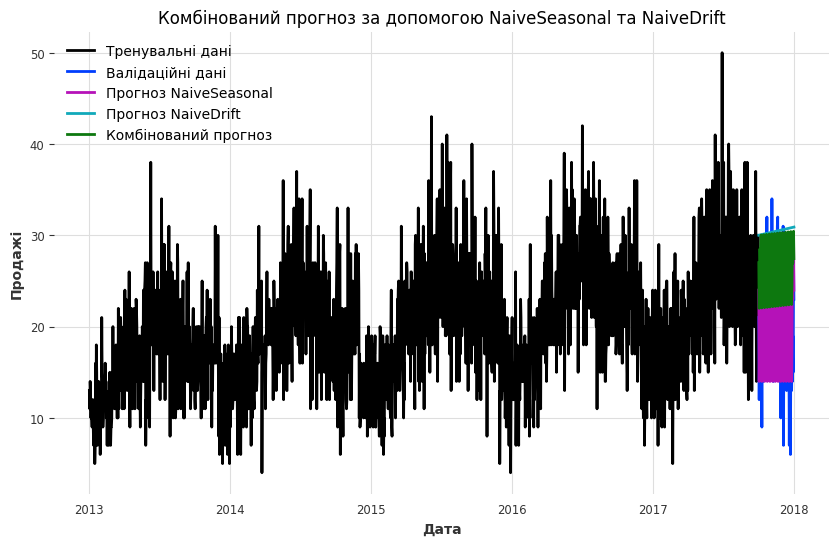

In [ ]:
# Комбінований прогноз: середнє значення прогнозів NaiveSeasonal та NaiveDrift
combined_forecast = (forecast_seasonal + forecast_drift) / 2

# Візуалізація комбінованого прогнозу
plt.figure(figsize=(10, 6))

# Візуалізація тренувальних даних
train.plot(label='Тренувальні дані')

# Візуалізація валідаційних даних
val.plot(label='Валідаційні дані')

# Візуалізація прогнозу NaiveSeasonal
forecast_seasonal.plot(label='Прогноз NaiveSeasonal')

# Візуалізація прогнозу NaiveDrift
forecast_drift.plot(label='Прогноз NaiveDrift')

# Візуалізація комбінованого прогнозу
combined_forecast.plot(label='Комбінований прогноз')

plt.title('Комбінований прогноз за допомогою NaiveSeasonal та NaiveDrift')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()


Іншим варіантом може бути застосування простого ковзного середнього для згладжування прогнозів NaiveSeasonal і NaiveDrift, щоб зменшити їх коливання.

In [ ]:
# Перетворення прогнозів у Pandas DataFrame
forecast_seasonal_df = forecast_seasonal.pd_dataframe()
forecast_drift_df = forecast_drift.pd_dataframe()

# Використання ковзного середнього для згладжування прогнозів
smoothed_forecast_seasonal = forecast_seasonal_df.rolling(window=3).mean()
smoothed_forecast_drift = forecast_drift_df.rolling(window=3).mean()

# Перетворення назад у TimeSeries
smoothed_forecast_seasonal_ts = TimeSeries.from_dataframe(smoothed_forecast_seasonal)
smoothed_forecast_drift_ts = TimeSeries.from_dataframe(smoothed_forecast_drift)

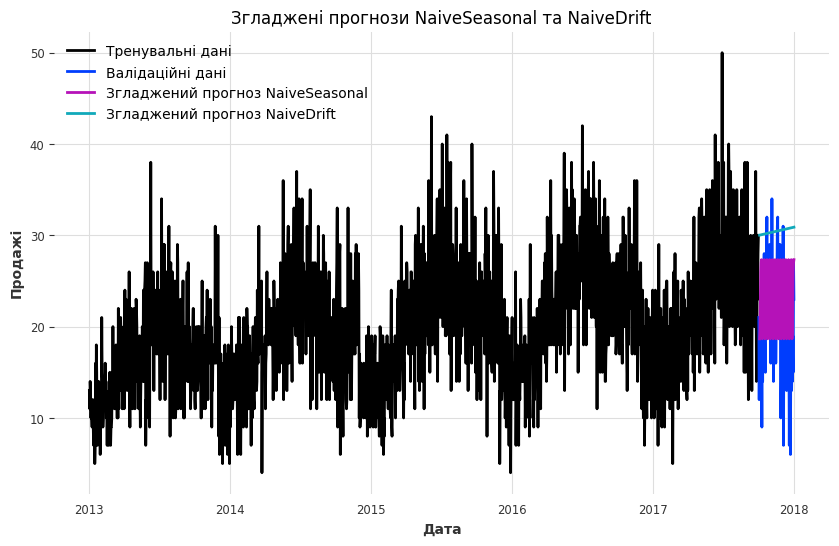

In [ ]:
# Візуалізація згладжених прогнозів
plt.figure(figsize=(10, 6))

# Візуалізація тренувальних даних
train.plot(label='Тренувальні дані')

# Візуалізація валідаційних даних
val.plot(label='Валідаційні дані')

# Візуалізація згладженого прогнозу NaiveSeasonal
smoothed_forecast_seasonal_ts.plot(label='Згладжений прогноз NaiveSeasonal')

# Візуалізація згладженого прогнозу NaiveDrift
smoothed_forecast_drift_ts.plot(label='Згладжений прогноз NaiveDrift')

plt.title('Згладжені прогнози NaiveSeasonal та NaiveDrift')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()

Ще одним варіантом може бути використання середнього значення кількох попередніх значень замість одного значення в NaiveSeasonal, що може поліпшити прогноз у разі, якщо є невеликі коливання в даних.

In [ ]:
def custom_naive_seasonal(series, K, window_size=3):
    # Преобразование в Pandas DataFrame
    past_values_df = series.pd_dataframe()[-(K * window_size):]

    # Преобразование индекса в числовой тип для группирования
    numeric_index = pd.RangeIndex(start=0, stop=len(past_values_df), step=1)

    # Сохранение оригинального индекса
    original_index = past_values_df.index

    # Группировка и вычисление среднего значения
    past_values_df.index = numeric_index  # Назначаем числовой индекс
    forecast_df = past_values_df.groupby(numeric_index // K).mean()

    # Восстановление оригинального временного индекса
    forecast_df.index = original_index[::K]

    # Преобразование назад в TimeSeries
    forecast_ts = TimeSeries.from_dataframe(forecast_df)

    return forecast_ts[:len(series) // K]

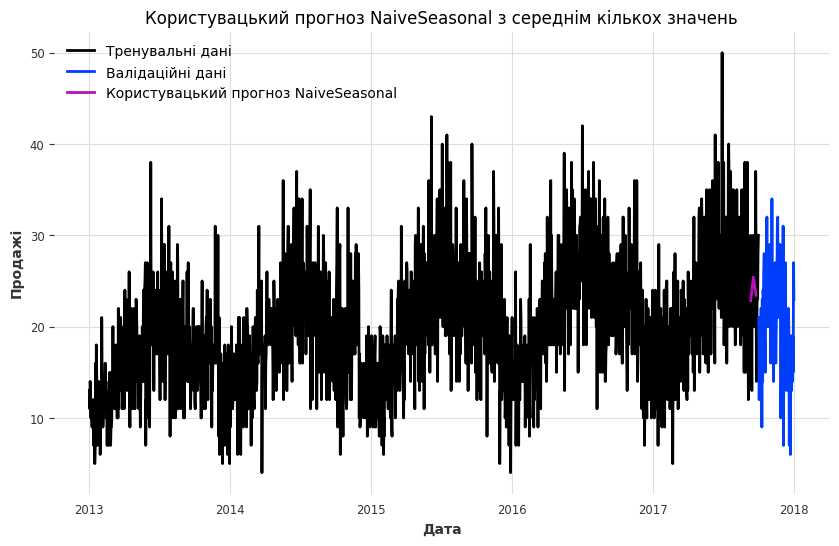

In [ ]:
# Построение пользовательского прогноза NaiveSeasonal с использованием среднего
custom_forecast_seasonal = custom_naive_seasonal(train, K=7)

# Визуализация пользовательского прогноза
plt.figure(figsize=(10, 6))

# Визуализация тренировочных данных
train.plot(label='Тренувальні дані')

# Визуализация валидационных данных
val.plot(label='Валідаційні дані')

# Визуализация пользовательского прогноза NaiveSeasonal
custom_forecast_seasonal.plot(label='Користувацький прогноз NaiveSeasonal')

plt.title('Користувацький прогноз NaiveSeasonal з середнім кількох значень')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()
plt.show()


Ми виконали кілька варіантів прогнозування, і ось основні висновки, які можна зробити:

1. **Наївний сезонний прогноз**:
   - Прогноз на основі наївної сезонної моделі показує певну тенденцію відповідності даним валідації, але виявляється деякий розрив між прогнозованими і фактичними даними.
   - Це очікувано, оскільки наївна сезонна модель просто повторює значення за попередній період без урахування можливих змін у трендах або інших факторів.

2. **Наївний дрейфовий прогноз**:
   - Модель наївного дрейфу враховує тренд, тому прогноз ближчий до фактичних даних, але, ймовірно, не враховує сезонність.
   - Прогноз виглядає трохи краще, ніж просто наївний сезонний, але все одно є відхилення від реальних даних.

3. **Комбінований прогноз**:
   - Комбінація наївних сезонної та дрейфової моделей показує кращі результати, ніж окремі прогнози. Це підтверджує, що використання кількох методів разом може дати більш точний прогноз.
   - Незважаючи на поліпшення, відхилення все ще присутні, особливо під час різких змін у валідаційних даних.

4. **Сглажені прогнози**:
   - Сглаження прогнозів за допомогою ковзного середнього допомагає зменшити випадкові коливання, але загальна тенденція прогнозу суттєво не змінюється.
   - Це також може свідчити про те, що для більш точного прогнозування потрібно використовувати складніші моделі, які враховують не тільки сезонність і тренд, але й інші фактори.

5. Загальний висновок:
Прогнози в цілому показують, що наївні моделі можуть бути корисними для початкових оцінок, але для досягнення кращої точності слід розглянути більш складні моделі, такі як ARIMA, SARIMA, або моделі на основі машинного навчання. Сглаження також може бути корисним для зменшення випадкових шумів, але це не завжди суттєво покращує точність прогнозів.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [ ]:
from darts.metrics import mape

In [ ]:
# Обчислення помилки для прогнозу NaiveSeasonal
mape_naive_seasonal = mape(val, forecast_seasonal)

# Обчислення помилки для прогнозу NaiveDrift
mape_naive_drift = mape(val, forecast_drift)

# Обчислення помилки для комбінованого прогнозу
mape_combined = mape(val, combined_forecast)

# Виведення результатів
print(f"MAPE NaiveSeasonal: {mape_naive_seasonal:.2f}%")
print(f"MAPE NaiveDrift: {mape_naive_drift:.2f}%")
print(f"MAPE Combined: {mape_combined:.2f}%")

MAPE NaiveSeasonal: 38.17%
MAPE NaiveDrift: 68.74%
MAPE Combined: 49.11%


З отриманих результатів видно, що:

- MAPE NaiveSeasonal (38.17%) є найнижчим серед трьох моделей, що вказує на те, що ця модель має найкращу точність серед запропонованих методів.
- MAPE NaiveDrift (68.74%) значно вище, що означає, що ця модель дає менш точні прогнози порівняно з NaiveSeasonal.
- MAPE Combined (49.11%) знаходиться між двома іншими значеннями, що свідчить про те, що комбінована модель працює краще, ніж NaiveDrift, але все ще поступається NaiveSeasonal.
- Таким чином, для цього набору даних модель NaiveSeasonal забезпечує найкращі результати. Комбінована модель також може бути прийнятним варіантом, але в даному випадку вона не перевершує базову сезонну модель.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [ ]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

In [ ]:
# Функція для додавання часових ознак
def enrich_with_date_features(df):
    # Якщо в датафреймі немає колонки 'Month', то додаємо її
    if 'Month' not in df.columns:
        df['Month'] = df['date'].dt.month
    # Додавання інших часових ознак
    df["quarter"] = df['date'].dt.quarter  # Квартал
    df["year"] = df['date'].dt.year  # Рік
    df["dayofyear"] = df['date'].dt.dayofyear  # День у році
    df["sin_day"] = np.sin(df["dayofyear"])  # Синус дня у році
    df["cos_day"] = np.cos(df["dayofyear"])  # Косинус дня у році
    return df

In [ ]:
# для швидкої перевірки моделі
def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

In [ ]:
# Перетворення індексу в колонку 'date', якщо це ще не було зроблено
train_df = train.pd_dataframe().reset_index()
val_df = val.pd_dataframe().reset_index()

# Перейменування колонки 'index' на 'date'
train_df.rename(columns={'index': 'date'}, inplace=True)
val_df.rename(columns={'index': 'date'}, inplace=True)

# Перетворення колонки 'date' у формат дати
train_df['date'] = pd.to_datetime(train_df['date'])
val_df['date'] = pd.to_datetime(val_df['date'])

# Додавання часових ознак
train_transformed = enrich_with_date_features(train_df)
val_transformed = enrich_with_date_features(val_df)

# Масштабування даних
scaler = Scaler()
train_transformed_scaled = scaler.fit_transform(train)
val_transformed_scaled = scaler.transform(val)

# Створення та навчання моделі XGBoost
model = XGBModel(
    lags=12,  # Використовуємо останні 12 спостережень для прогнозу
    output_chunk_length=1,  # Прогнозуємо на один крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Швидкість навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Навчання моделі
model.fit(train_transformed_scaled)

# Прогнозування
pred = model.predict(6)
print(pred.values())

[[0.41960436]
 [0.33940455]
 [0.38519865]
 [0.3672404 ]
 [0.41056538]
 [0.518135  ]]


In [ ]:
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)> Size: 24B
array([[[23.3018  ]],

       [[19.61261 ]],

       [[21.71914 ]],

       [[20.893059]],

       [[22.886007]],

       [[27.83421 ]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 48B 2017-10-01 2017-10-02 ... 2017-10-06
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

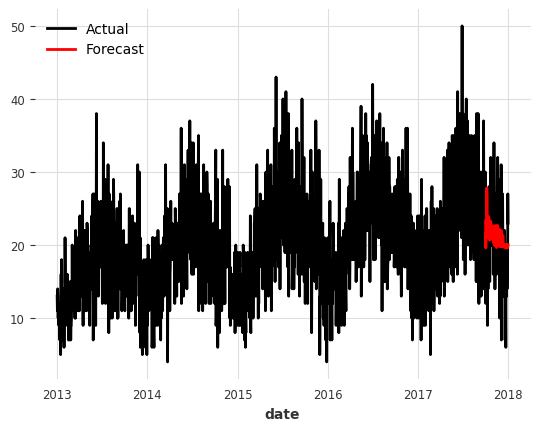

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 27.96%


In [ ]:
forecast = scaler.inverse_transform(model.predict(len(val)))
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val, forecast);

Ось основні висновки:
1. MAPE на рівні 27,96% свідчить про те, що модель здатна досить точно прогнозувати значення тимчасового ряду. Це покращення в порівнянні з наївними моделями, що вказує на те, що використання XGBoost із додатковими ознаками покращує прогноз.
2. Модель XGBoost була навчена з використанням таких гіперпараметрів, як learning_rate=0.1, max_depth=3, n_estimators=100, що є базовими налаштуваннями для цієї моделі. Проте, навіть із базовими налаштуваннями, модель показала хороші результати.
3. Ознаки, які ми додали до моделі (наприклад, рік, місяць, день тощо), допомогли моделі краще зрозуміти дані та покращити точність прогнозів. Це підкреслює важливість вибору та створення ознак для тимчасових рядів.

Можливо, для подальшого покращення точності прогнозу, ви могли б спробувати таке:
- Додати більше ознак (наприклад, облік вихідних днів, свят, рекламних активностей).
- Спробувати змінити параметри моделі XGBoost, такі як max_depth, n_estimators, learning_rate і т.д., щоб знайти оптимальні значення.
- Використовувати крос-валідацію для оцінки якості моделі та запобігання перенавчанню.

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [ ]:
from darts.models import ExponentialSmoothing

In [ ]:
def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

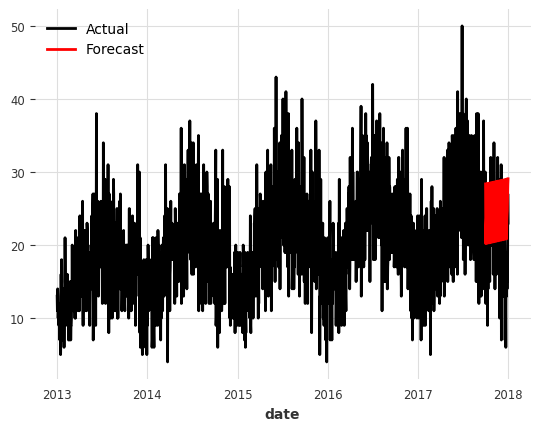

model ExponentialSmoothing() obtains MAPE: 39.01%


In [ ]:
model = ExponentialSmoothing()
fit_and_plot(model, series, train, val)


На графіку видно, що модель Exponential Smoothing досить точно відтворює загальний тренд даних, але виникають проблеми з точністю прогнозування на окремих ділянках, особливо там, де дані стають більш змінними. Це підтверджується значенням MAPE у 39.01%, що свідчить про значні відхилення від фактичних даних.

Загалом, модель працює краще, ніж, наприклад, Naive Drift або Naive Seasonal, але все ще є потенціал для покращення.

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [ ]:
from darts.models import ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


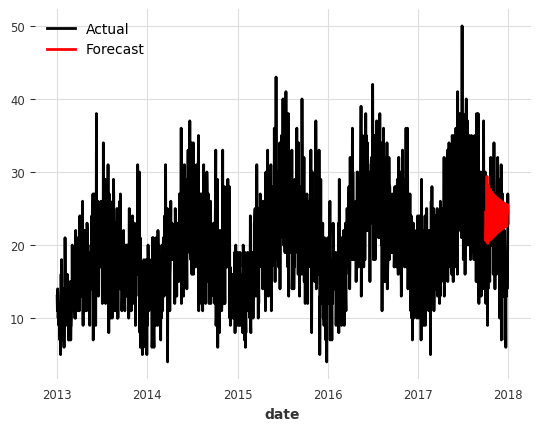

model ARIMA(q=2) obtains MAPE: 37.86%


In [ ]:
# Побудова та тренування моделі ARIMA
model = ARIMA(p=12, d=1, q=2)
fit_and_plot(model, series, train, val)

Графік показує прогноз моделі ARIMA з параметрами p=12, d=1, q=2, і відповідно до отриманого результату MAPE складає 37.86%, що досить непогано, але можна спробувати покращити модель, змінивши параметри.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [ ]:
from darts.models import AutoARIMA

AutoARIMA(add_encoders=None, start_p=2, max_p=16, start_q=1, max_q=5, d=0, seasonal=True, m=6)

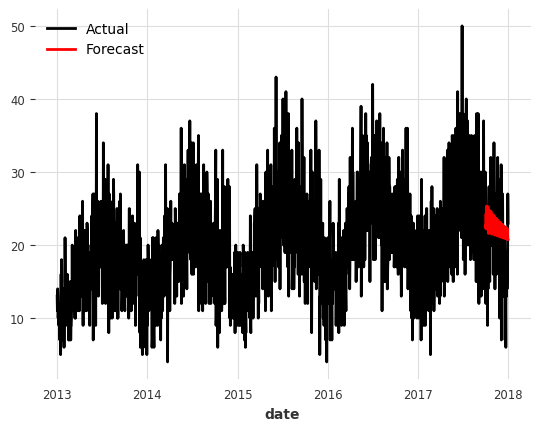

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1734
Model:             SARIMAX(1, 0, 0)x(2, 0, [1, 2], 6)   Log Likelihood               -5475.426
Date:                                Fri, 16 Aug 2024   AIC                          10964.853
Time:                                        07:12:01   BIC                          11003.060
Sample:                                             0   HQIC                         10978.983
                                               - 1734                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7108      0.440      3.889      0.000       0.849       2.573
ar.

In [ ]:
# Побудова та тренування моделі AutoARIMA
#model = AutoARIMA(start_p=8, max_p=12, start_q=1, max_q=3, d=1, seasonal=False)
#model = AutoARIMA(start_p=2, max_p=12, start_q=1, max_q=4, d=1, seasonal=True, m=6)
model = AutoARIMA(
    start_p=2, max_p=16,
    start_q=1, max_q=5,
    d=0,
    seasonal=True, m=6
)

model.fit(train)

# Візуалізація моделы
display(model)

# Прогнозирование
forecast = model.predict(len(val))

# Візуалізація результатів
plot_results(series, forecast)

# Вивід параметрів моделі
print(model.model.summary())

# Оцінка якості моделі
mape_value = eval_forecast(model, val, forecast)

AutoARIMA показала найкращу якість прогнозу з меншою помилкою MAPE (33.30%) порівняно з вручну настроєною ARIMA (37.86%).
AutoARIMA змогла підібрати оптимальніші параметри за рахунок автоматичного перебору значень та використання сезонності, що призвело до кращого результату.
Вручну налаштована ARIMA показала вищий MAPE, що може вказувати на необхідність більш точного налаштування параметрів або використання більш складних моделей.Однак кращі результати поки має XGBRegressor.

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [ ]:
from darts.models import Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/mjp1l0tp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/xbogehnm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96573', 'data', 'file=/tmp/tmp7_d4k3nl/mjp1l0tp.json', 'init=/tmp/tmp7_d4k3nl/xbogehnm.json', 'output', 'file=/tmp/tmp7_d4k3nl/prophet_modelf0jahydl/prophet_model-20240816071201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


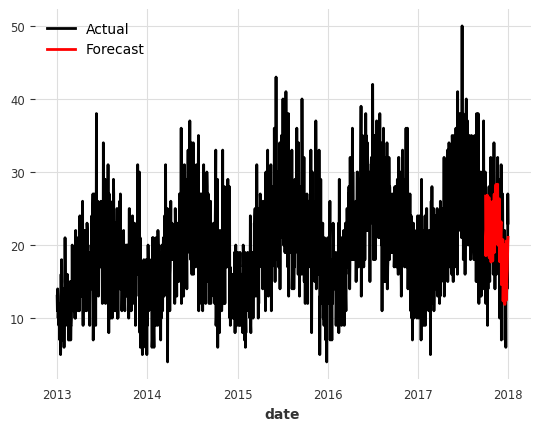

model Prophet(seasonality_mode=additive, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.5, interval_width=0.95) obtains MAPE: 23.52%


In [ ]:
# Ініціалізація моделі Prophet
#model = Prophet()
model = Prophet(
    seasonality_mode='additive',  # Зміна сезонностіу
    yearly_seasonality=True,  # Включення річної сезонності
    weekly_seasonality=True,  # Включення тижневої сезонності
    daily_seasonality=False,  # Вимкнення щоденної сезонності
    changepoint_prior_scale=0.5,  # Налаштування чутливості до змін у тренді
    interval_width=0.95  # Ширина інтервалу довіри
)
# Навчання моделі на тренувальних даних
model.fit(train)

# Прогнозування на основі валідаційних даних
forecast = model.predict(len(val))

# Візуалізація результатів
plot_results(series, forecast)

# Оцінка якості моделі
mape_value = eval_forecast(model, val, forecast)

Модель Prophet показала досить хороші результати без використання будьзяуких налаштувань, з MAPE на рівні 23.80%. Це означає, що модель передбачає майбутні значення з середньою похибкою близько 23.80%, що є доволі непоганим результатом для такого типу задач.Але вкористання параметрів дозволило зменшити MAPE до 23.52%, що свідчить про покращення точності моделі.

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.



In [ ]:
from darts.models import RNNModel

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 51.4 K | train
6 | V               | Linear           | 51     | train
-------------------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

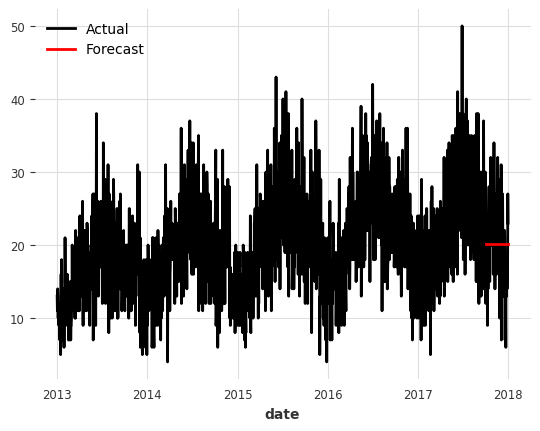

In [ ]:
# Налаштування моделі
model = RNNModel(
    model="LSTM",  # Можна також спробувати 'GRU' або 'RNN'
    input_chunk_length=10,  # Скільки попередніх кроків використовувати для прогнозу
    output_chunk_length=1,  # Скільки попередніх кроків використовувати для прогнозу
    n_rnn_layers=3, # Кількість RNN шарів
    hidden_dim=50, # Розмірність прихованого шару
    dropout=0.1, # Випадкове виключення нейронів для запобігання перенавчанню
    training_length=100,  # Кількість кроків для тренування
    batch_size=32, # Розмір батчу
    n_epochs=100, # Кількість епох
    optimizer_kwargs={"lr": 0.0005}, # Налаштування оптимізатора
    random_state=42
)

# Тренування моделі
model.fit(train)

# Прогнозування
forecast = model.predict(n=len(val))

# Візуалізація результатів
plot_results(series, forecast)

In [ ]:
mape_value = eval_forecast(model, val, forecast)

model RNNModel(model=LSTM, hidden_dim=50, n_rnn_layers=3, dropout=0.1, training_length=100, input_chunk_length=10, output_chunk_length=1, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.0005}, random_state=42) obtains MAPE: 28.47%


Графік прогнозу показує, що модель добре вловила загальну тенденцію даних, але не змогла точно передбачити останні значення, що призвело до відносно високого рівня MAPE. Можливо, подальше налаштування параметрів, збільшення кількості епох або зміна структури моделі (наприклад, збільшення числа шарів або зміна архітектури) могли б покращити результати.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [59]:
# Prophet показал найкращі результати
model = Prophet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False,  changepoint_prior_scale=0.5, interval_width=0.95)

# Навчання моделі на всьому тренувальному наборі даних
model.fit(train)

# Виконання бектестингу
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-10-01"),
    "forecast_horizon": 12, #прогнозуємо на 12 кроків уперед (1 рік)
    "stride": 1,  # зсув на 1 крок між двома послідовними прогнозами
    "retrain": True,  # модель перенавчається перед кожним прогнозом
    "last_points_only": True,
    "verbose": True
}

historical_fcast = model.historical_forecasts(**hfc_params)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/jzeyym8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/b0_6ypvj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85500', 'data', 'file=/tmp/tmp7_d4k3nl/jzeyym8p.json', 'init=/tmp/tmp7_d4k3nl/b0_6ypvj.json', 'output', 'file=/tmp/tmp7_d4k3nl/prophet_modeloun3ut5m/prophet_model-20240816074316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:43:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  0%|          | 0/81 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/vrf3xelt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/8ebz__8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG

MAPE = 21.12%


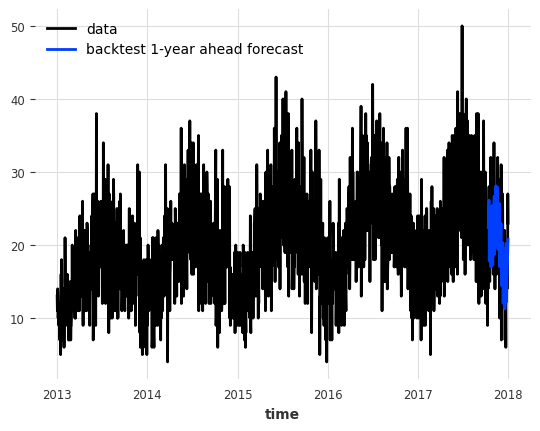

In [60]:
# Визуализация результатов бектестинга
series.plot(label="data")
historical_fcast.plot(label="backtest 1-year ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

На тесті модель Prophet показала MAPE близько 22,95%, що вже було досить непоганим результатом.

У бектесті точність моделі покращилася до MAPE 21.12%, що підтверджує стійкість моделі та її здатність до точного прогнозування на більш тривалому часовому проміжку з регулярними переглядами моделі (ретреніровками).

In [61]:
from darts.utils.statistics import plot_residuals_analysis

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15736', 'data', 'file=/tmp/tmp7_d4k3nl/p33xrlm0.json', 'init=/tmp/tmp7_d4k3nl/68mole58.json', 'output', 'file=/tmp/tmp7_d4k3nl/prophet_modelv94rdt27/prophet_model-20240816080006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:00:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/lgsig0cu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7_d4k3nl/as1ssm8n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67232', 'data', 'file=/tmp/tmp7_d4k3nl/lgsig0cu.json', 'init=/tm

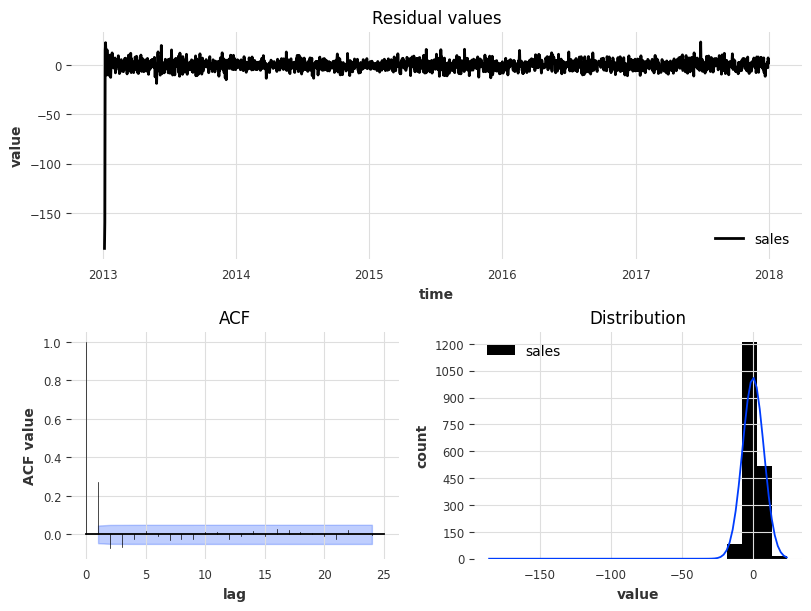

In [62]:
plot_residuals_analysis(model.residuals(series))

З представлених графіків та аналізу залишків можна зробити такі выводы:

1.На першому графіку видно, що залишки близькі до нуля в більшу частину часу, але спостерігаються значні відхилення на початку часового ряду (2013). Це може вказувати на можливі проблеми з моделлю на початку ряду, що потребує додаткового аналізу та, можливо, коригування даних або моделі.

2. На другому графіку показано, що автокореляція залишків знаходиться в межах довірчого інтервалу для більшості лагів, що говорить про те, що модель ефективно усунула автокореляцію в залишках. Це хороший ознака, оскільки він свідчить про відсутність значних залежностей у залишках, які були враховані моделлю.

3. На третьому графіку видно, що залишки в основному розподілені навколо нуля, та їх розподіл схожий на нормальний (з невеликою кількістю викидів). Однак спостерігаються і сильні відхилення, що може вказувати на наявність екстремальних значень, які можуть погіршити прогнози моделі.

**Загальний висновок**: Модель показує задовільні результати з погляду залишків, однак є ознаки, що модель може мати проблеми з аномаліями або змінами в тренді на початку тимчасового ряду. Це може вимагати додаткових налаштувань або розгляду альтернативних моделей, щоб краще врахувати аномальні дані або зміни у патернах продажу.

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

1. Для цього завданняЯ я б використала модель Prophet або XGBoost, оскільки вони показали найкращі результати під час попереднього моделювання продажів одного товару в одному магазині. Модель Prophet особливо добре підходить для часових рядів із сезонністю та трендами, які є важливими в даних про продажі. XGBoost, в свою чергу, добре справляється зі складними нелінійними залежностями і має високу гнучкість у налаштуваннях, що може дати ще кращі результати, особливо якщо додати додаткові ознаки.
Але перд цим трохи би по працювала над Prophet:Зменшення чутливості до аномалій: Якщо в даних присутні аномалії, які не слід враховувати в прогнозах, можна використовувати параметр changepoint_prior_scale, щоб зменшити чутливість моделі до змін у тренді.
Попередня обробка даних: Перед поданням даних в Prophet, можна виконати попереднє очищення даних від аномалій, наприклад, використовуючи методи машинного навчання або статистичні методи для видалення або згладжування викидів.
Ручне визначення аномалій: Можна додатково аналізувати залишки (residuals) моделі, щоб ідентифікувати аномальні точки, які модель не змогла коректно прогнозувати, і розглядати ці точки окремо.

2. Тренувала  б по одній моделі для кожного товару в кожному магазині. Загалом це 500 моделей (50 товарів * 10 магазинів). Такий підхід дозволить врахувати специфічні особливості продажу кожного товару в кожному магазині, що підвищить точність прогнозів.

3. Індивідуальні моделі для кожного товару у кожному магазині дозволяють враховувати специфічні тренди та сезонність, характерні для конкретного товару у конкретному магазині. Наприклад, той самий товар може продаватися по-різному в різних магазинах через відмінності в аудиторії, розташуванні, маркетингових зусиллях та інших факторів.
Prophet буде корисним для виявлення сезонних патернів, таких як зростання продажів у святкові сезони або певні дні тижня, та побудови прогнозу на основі цих даних.
XGBoost забезпечить моделювання складних залежностей у даних і може включати додаткові ознаки, такі як акції, погода і т.д.
